####**Exploring train dataset** 

In [1]:
import os

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        n = 0
        for f in files:
            n = n+1
            if n>5:
                print('{}{}'.format(subindent, f),end = "  ...... \n")
                break
            print('{}{}'.format(subindent, f))
img_dir = 'img/virtual_img_pp_split_by_gender/'

list_files(img_dir)

/
TRAIN/
    FEMALE/
        058_Female_Fluting009.png
        021_Female_Fluting005.png
        026_Female_Fluting001.png
        038_Female_Fluting002.png
        032_Female_Fluting003.png
        093_Female_Fluting003.png  ...... 
    MALE/
        010_Male_Fluting004.png
        083_Male_Fluting002.png
        002_Male_Fluting005.png
        024_Male_Fluting006.png
        029_Male_Fluting006.png
        059_Male_Fluting007.png  ...... 
TEST/
    FEMALE/
        035_Female_Fluting006.png
        066_Female_Fluting005.png
        066_Female_Fluting009.png
        036_Female_Fluting007.png
        082_Female_Fluting008.png
        005_Female_Fluting001.png  ...... 
    MALE/
        073_Male_Fluting003.png
        013_Male_Fluting008.png
        096_Male_Fluting003.png
        013_Male_Fluting003.png
        077_Male_Fluting004.png
        073_Male_Fluting005.png  ...... 


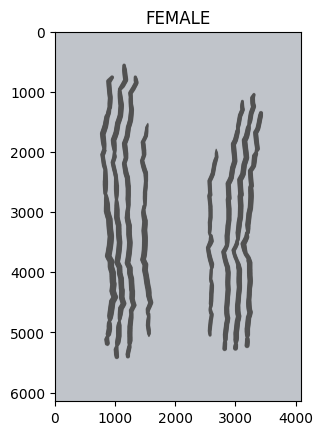

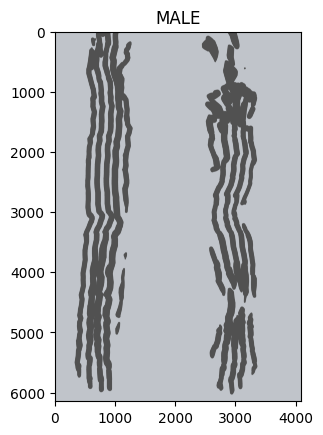

In [2]:
import cv2
import matplotlib.pyplot as plt

PATH_TRAIN =  os.path.join(img_dir, 'TRAIN')

PATH_TEST = os.path.join(img_dir, 'TEST')

normal_sample = cv2.imread(PATH_TRAIN+"/FEMALE/"+os.listdir(PATH_TRAIN+"/FEMALE")[3])
infected_sample = cv2.imread(PATH_TRAIN+"/MALE/"+os.listdir(PATH_TRAIN+"/MALE")[2])

plt.imshow(normal_sample)
plt.title("FEMALE")
plt.show()

plt.imshow(infected_sample)
plt.title("MALE")
plt.show()

The difference can be seen with different visualizations below

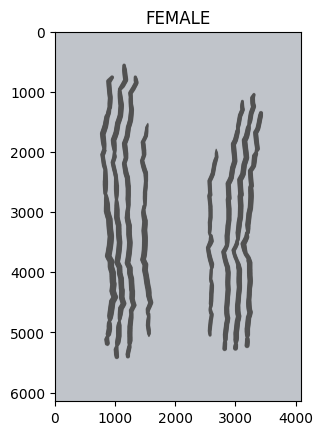

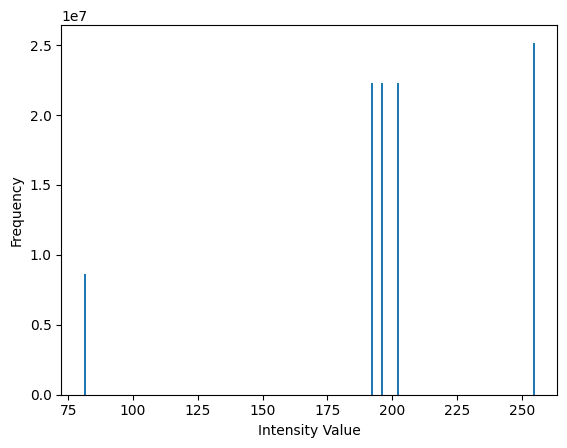

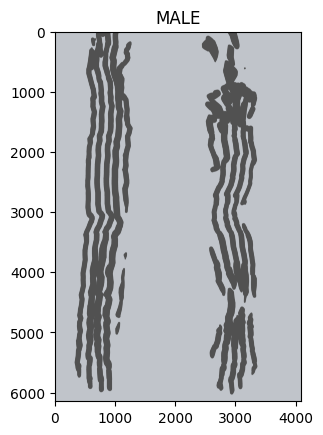

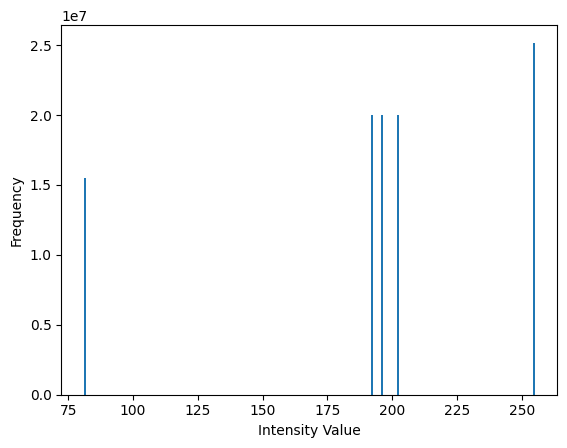

In [3]:
from skimage import io
import matplotlib.pyplot as plt

plt.imshow(normal_sample)
plt.title("FEMALE")
plt.show()

image = io.imread(PATH_TRAIN+"/FEMALE/"+os.listdir(PATH_TRAIN+"/FEMALE")[3])
ax = plt.hist(image.ravel(), bins = 256)
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.show()

plt.imshow(infected_sample)
plt.title("MALE")
plt.show()

image = io.imread(PATH_TRAIN+"/MALE/"+os.listdir(PATH_TRAIN+"/MALE")[2])
ax = plt.hist(image.ravel(), bins = 256)
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.show()

####**Initializing the data loader** 

vgg16 pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.<br />
The images have to be loaded in to a range of [0, 1] and then normalized using:
 #### mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225] <br />
 
 We are applying augmentation like random rotation , horizontal and vertical flips to make sre the model doesn't overfit or learn the wrong features
 

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import time
import torchvision
from PIL import ImageFile
import matplotlib.pyplot as plt
import cv2
# ghf
ImageFile.LOAD_TRUNCATED_IMAGES = True # To prevent error during loading broken images

PATH_TRAIN =  os.path.join(img_dir, 'TRAIN')
PATH_TEST = os.path.join(img_dir, 'TEST')

# NOW TEST is a validation set.
EPOCHS = 500
BATCH_SIZE = 32
TOTAL_SIZE = len(os.listdir(PATH_TRAIN + "/FEMALE")) + len(
    os.listdir(PATH_TRAIN + "/MALE")
)
TOTAL_TEST_SIZE = len(os.listdir(PATH_TEST + "/FEMALE")) + len(
    os.listdir(PATH_TEST + "/MALE")
)
STEPS_PER_EPOCH = TOTAL_SIZE // BATCH_SIZE
STEPS_PER_TEST_EPOCH = TOTAL_TEST_SIZE // BATCH_SIZE
IMAGE_H, IMAGE_W = 224, 224

print(TOTAL_SIZE , TOTAL_TEST_SIZE)

661 153


In [5]:
transform = torchvision.transforms.Compose(
    [  # Applying Augmentation
        torchvision.transforms.Resize((IMAGE_H, IMAGE_W)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(30),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)  # Normalizing data

# Intitalizing the train data loader and applying the transformations

train_dataset = torchvision.datasets.ImageFolder(root=PATH_TRAIN, transform=transform)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=1, shuffle=True
)

# Intitalizing the test data loader

test_dataset = torchvision.datasets.ImageFolder(
    root=PATH_TEST, transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, num_workers=1, shuffle=True
)

## **Initializing pretrained resnet18 model** 



<img src="https://d2l.ai/_images/residual-block.svg" width="500px">




ResNet, short for Residual Networks is a classic neural network used as a backbone for many computer vision tasks. This model was the winner of ImageNet challenge in 2015. The fundamental breakthrough with ResNet was it allowed us to train extremely deep neural networks with 150+layers successfully. Prior to ResNet training very deep neural networks was difficult due to the problem of vanishing gradients.
However, increasing network depth does not work by simply stacking layers together. Deep networks are hard to train because of the notorious vanishing gradient problem — as the gradient is back-propagated to earlier layers, repeated multiplication may make the gradient extremely small. As a result, as the network goes deeper, its performance gets saturated or even starts degrading rapidly.

In [6]:
model_ft = torchvision.models.resnet18(pretrained=True, progress=True)  # Initializing resnet18


/home/zhongyi/anaconda3/envs/lipa/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zhongyi/anaconda3/envs/lipa/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:

num_ftrs = model_ft.fc.in_features # Getting last layer's output features
model_ft.fc = nn.Linear(num_ftrs, 2) # Modifying the last layer accordng to our need

## **Initializing optimizers and loss function** <br/>
We will also specify the learning rate of the optimiser, here in this case it is set at 0.0001. If our training is bouncing a lot on epochs then we need to decrease the learning rate so that we can reach global minima.

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft.to(device)  # Sending model to device
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model_ft.parameters(), lr=0.000001
)  # lr should be kept low so that the pre-trained weights don't change easily

####**TESTING THE MODEL** 

In [9]:
def get_test():
    test_loss = []
    correct = 0
    incorrect = 0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    for batch_idx, (data, target) in enumerate(test_loader):
        if batch_idx == STEPS_PER_TEST_EPOCH:
            break

        # Model is used to predict the test data so we are switching off the gradient

        with torch.no_grad():

            data = data.to(device)
            target = target.long().to(device)
            output = model_ft(data)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(output, target)

            # Note that optimizer is not used because the model shouldn't learn the test dataset

            for i in range(BATCH_SIZE):
                a = []
                for j in output[i]:
                    a.append(float(j.detach()))

                pred = a.index(max(a))

                if pred == int(target[i]):
                    correct = correct + 1

                else:
                    incorrect = incorrect + 1

        test_loss.append(float(loss.detach()))
    print("CORRECT: " + str(correct), "INCORRECT: " + str(incorrect),"TEST ACCURACY: "+str(correct/(correct+incorrect)))
    return (
            correct/(incorrect+correct),
            sum(test_loss)/len(test_loss),
    )





In [10]:
acc_ , loss_ = get_test()
print("ACCURACY AND LOSS BEFORE TUNING")
print("ACCURACY : "+str(acc_),"LOSS : "+str(loss_))

CORRECT: 63 INCORRECT: 65 TEST ACCURACY: 0.4921875
ACCURACY AND LOSS BEFORE TUNING
ACCURACY : 0.4921875 LOSS : 0.7358256429433823


####**TUNING THE MODEL (TRAINING)** 

In [ ]:
avg_test_loss_history = []
avg_test_accuracy_history = []
avg_train_loss_history = []
avg_train_accuracy_history = []

loss_history = []
accuracy_history = []

new_best = 0

for i in range(EPOCHS):

    start = time.time()
    print(
        "-----------------------EPOCH "
        + str(i)
        + " -----------------------------------"
    )
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx == STEPS_PER_EPOCH:
            break
        optimizer.zero_grad()  # Resetting gradients after each optimizations
        # Sending input , target to device
        data = data.to(device) 
        target = target.to(device)
        output = model_ft(data)
        loss = criterion(output, target.reshape((BATCH_SIZE,)).long())
        loss_history.append(loss.detach())
        # The loss variable has gradient attached to it so we are removing it so that it can be used to plot graphs
        loss.backward()
        optimizer.step()  # Optimizing the model

        # Checking train accuracy

        correct = 0
        incorrect = 0
        for p in range(BATCH_SIZE):
            a = []
            for j in output[p]:
                a.append(float(j.detach()))

            pred = a.index(max(a))

            if pred == int(target[p]):
                correct = correct + 1

            else:

                incorrect = incorrect + 1

        print(
            "\r EPOCH "
            + str(i)
            + " MINIBATCH: "
            + str(batch_idx)
            + "/"
            + str(STEPS_PER_EPOCH)
            + " LOSS: "
            + str(loss_history[-1]),
            end = ""
            
        )
        
        accuracy_history.append(correct/(correct+incorrect))

    end = time.time()
    print(
        " \n EPOCH "
        + str(i)
        + " LOSS "
        + str(sum(loss_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
        + " ETA: "
        + str(end - start)
        + " \n MAX LOSS: "
        + str(max(loss_history[-STEPS_PER_EPOCH:]))
        + " MIN LOSS: "
        + str(min(loss_history[-STEPS_PER_EPOCH:]))
        + " TRAIN ACCURACY: "
        + str(sum(accuracy_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
    )
    
    avg_train_loss_history.append(sum(loss_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
    avg_train_accuracy_history.append(sum(accuracy_history[-STEPS_PER_EPOCH:]) / STEPS_PER_EPOCH)
    
    test_acc , test_loss  = get_test()
    
    avg_test_accuracy_history.append(test_acc)
    avg_train_loss_history.append(test_loss)
    
    if test_acc>new_best: 
        new_best = test_acc
        torch.save(model_ft.state_dict(), "resnet_model_lr0.000001_split_82.pth") # Saving our best model



-----------------------EPOCH 0 -----------------------------------
 EPOCH 0 MINIBATCH: 19/20 LOSS: tensor(0.6883, device='cuda:0') 
 EPOCH 0 LOSS tensor(0.7108, device='cuda:0') ETA: 166.863285779953 
 MAX LOSS: tensor(0.7942, device='cuda:0') MIN LOSS: tensor(0.6493, device='cuda:0') TRAIN ACCURACY: 0.51875
CORRECT: 59 INCORRECT: 69 TEST ACCURACY: 0.4609375
-----------------------EPOCH 1 -----------------------------------
 EPOCH 1 MINIBATCH: 19/20 LOSS: tensor(0.7573, device='cuda:0') 
 EPOCH 1 LOSS tensor(0.7083, device='cuda:0') ETA: 164.17968153953552 
 MAX LOSS: tensor(0.7652, device='cuda:0') MIN LOSS: tensor(0.6608, device='cuda:0') TRAIN ACCURACY: 0.5078125
CORRECT: 56 INCORRECT: 72 TEST ACCURACY: 0.4375
-----------------------EPOCH 2 -----------------------------------
 EPOCH 2 MINIBATCH: 19/20 LOSS: tensor(0.6993, device='cuda:0') 
 EPOCH 2 LOSS tensor(0.7088, device='cuda:0') ETA: 164.40391778945923 
 MAX LOSS: tensor(0.7660, device='cuda:0') MIN LOSS: tensor(0.6473, device

CORRECT: 76 INCORRECT: 52 TEST ACCURACY: 0.59375
-----------------------EPOCH 23 -----------------------------------
 EPOCH 23 MINIBATCH: 19/20 LOSS: tensor(0.6782, device='cuda:0') 
 EPOCH 23 LOSS tensor(0.6285, device='cuda:0') ETA: 163.40838408470154 
 MAX LOSS: tensor(0.7126, device='cuda:0') MIN LOSS: tensor(0.5419, device='cuda:0') TRAIN ACCURACY: 0.65
CORRECT: 75 INCORRECT: 53 TEST ACCURACY: 0.5859375
-----------------------EPOCH 24 -----------------------------------
 EPOCH 24 MINIBATCH: 19/20 LOSS: tensor(0.6420, device='cuda:0') 
 EPOCH 24 LOSS tensor(0.6294, device='cuda:0') ETA: 165.0237593650818 
 MAX LOSS: tensor(0.6929, device='cuda:0') MIN LOSS: tensor(0.5048, device='cuda:0') TRAIN ACCURACY: 0.6421875
CORRECT: 74 INCORRECT: 54 TEST ACCURACY: 0.578125
-----------------------EPOCH 25 -----------------------------------
 EPOCH 25 MINIBATCH: 19/20 LOSS: tensor(0.6173, device='cuda:0') 
 EPOCH 25 LOSS tensor(0.6184, device='cuda:0') ETA: 163.53066539764404 
 MAX LOSS: tenso

 EPOCH 45 MINIBATCH: 19/20 LOSS: tensor(0.5891, device='cuda:0') 
 EPOCH 45 LOSS tensor(0.5811, device='cuda:0') ETA: 163.5863037109375 
 MAX LOSS: tensor(0.7273, device='cuda:0') MIN LOSS: tensor(0.4847, device='cuda:0') TRAIN ACCURACY: 0.7125
CORRECT: 79 INCORRECT: 49 TEST ACCURACY: 0.6171875
-----------------------EPOCH 46 -----------------------------------
 EPOCH 46 MINIBATCH: 19/20 LOSS: tensor(0.5927, device='cuda:0') 
 EPOCH 46 LOSS tensor(0.5835, device='cuda:0') ETA: 163.8678388595581 
 MAX LOSS: tensor(0.6623, device='cuda:0') MIN LOSS: tensor(0.4866, device='cuda:0') TRAIN ACCURACY: 0.7171875
CORRECT: 81 INCORRECT: 47 TEST ACCURACY: 0.6328125
-----------------------EPOCH 47 -----------------------------------
 EPOCH 47 MINIBATCH: 19/20 LOSS: tensor(0.5543, device='cuda:0') 
 EPOCH 47 LOSS tensor(0.5844, device='cuda:0') ETA: 164.76991772651672 
 MAX LOSS: tensor(0.7259, device='cuda:0') MIN LOSS: tensor(0.4888, device='cuda:0') TRAIN ACCURACY: 0.7046875
CORRECT: 74 INCORREC

CORRECT: 79 INCORRECT: 49 TEST ACCURACY: 0.6171875
-----------------------EPOCH 68 -----------------------------------
 EPOCH 68 MINIBATCH: 19/20 LOSS: tensor(0.4607, device='cuda:0') 
 EPOCH 68 LOSS tensor(0.5505, device='cuda:0') ETA: 164.60238766670227 
 MAX LOSS: tensor(0.6812, device='cuda:0') MIN LOSS: tensor(0.4385, device='cuda:0') TRAIN ACCURACY: 0.715625
CORRECT: 83 INCORRECT: 45 TEST ACCURACY: 0.6484375
-----------------------EPOCH 69 -----------------------------------
 EPOCH 69 MINIBATCH: 19/20 LOSS: tensor(0.4780, device='cuda:0') 
 EPOCH 69 LOSS tensor(0.5550, device='cuda:0') ETA: 164.8306519985199 
 MAX LOSS: tensor(0.6363, device='cuda:0') MIN LOSS: tensor(0.4780, device='cuda:0') TRAIN ACCURACY: 0.703125
CORRECT: 83 INCORRECT: 45 TEST ACCURACY: 0.6484375
-----------------------EPOCH 70 -----------------------------------
 EPOCH 70 MINIBATCH: 19/20 LOSS: tensor(0.5277, device='cuda:0') 
 EPOCH 70 LOSS tensor(0.5702, device='cuda:0') ETA: 164.44659161567688 
 MAX LOSS:

 EPOCH 90 MINIBATCH: 19/20 LOSS: tensor(0.5391, device='cuda:0') 
 EPOCH 90 LOSS tensor(0.5532, device='cuda:0') ETA: 161.51446747779846 
 MAX LOSS: tensor(0.6716, device='cuda:0') MIN LOSS: tensor(0.4382, device='cuda:0') TRAIN ACCURACY: 0.7171875
CORRECT: 84 INCORRECT: 44 TEST ACCURACY: 0.65625
-----------------------EPOCH 91 -----------------------------------
 EPOCH 91 MINIBATCH: 19/20 LOSS: tensor(0.5086, device='cuda:0') 
 EPOCH 91 LOSS tensor(0.5453, device='cuda:0') ETA: 164.22777724266052 
 MAX LOSS: tensor(0.7187, device='cuda:0') MIN LOSS: tensor(0.4186, device='cuda:0') TRAIN ACCURACY: 0.73125
CORRECT: 86 INCORRECT: 42 TEST ACCURACY: 0.671875
-----------------------EPOCH 92 -----------------------------------
 EPOCH 92 MINIBATCH: 19/20 LOSS: tensor(0.5626, device='cuda:0') 
 EPOCH 92 LOSS tensor(0.5394, device='cuda:0') ETA: 162.25869250297546 
 MAX LOSS: tensor(0.7192, device='cuda:0') MIN LOSS: tensor(0.4424, device='cuda:0') TRAIN ACCURACY: 0.721875
CORRECT: 86 INCORRECT

CORRECT: 85 INCORRECT: 43 TEST ACCURACY: 0.6640625
-----------------------EPOCH 113 -----------------------------------
 EPOCH 113 MINIBATCH: 19/20 LOSS: tensor(0.5324, device='cuda:0') 
 EPOCH 113 LOSS tensor(0.5198, device='cuda:0') ETA: 164.0449459552765 
 MAX LOSS: tensor(0.6676, device='cuda:0') MIN LOSS: tensor(0.4273, device='cuda:0') TRAIN ACCURACY: 0.74375
CORRECT: 85 INCORRECT: 43 TEST ACCURACY: 0.6640625
-----------------------EPOCH 114 -----------------------------------
 EPOCH 114 MINIBATCH: 19/20 LOSS: tensor(0.5475, device='cuda:0') 
 EPOCH 114 LOSS tensor(0.5237, device='cuda:0') ETA: 163.68409085273743 
 MAX LOSS: tensor(0.6056, device='cuda:0') MIN LOSS: tensor(0.4290, device='cuda:0') TRAIN ACCURACY: 0.7421875
CORRECT: 87 INCORRECT: 41 TEST ACCURACY: 0.6796875
-----------------------EPOCH 115 -----------------------------------
 EPOCH 115 MINIBATCH: 19/20 LOSS: tensor(0.5885, device='cuda:0') 
 EPOCH 115 LOSS tensor(0.5251, device='cuda:0') ETA: 164.85810470581055 
 

 EPOCH 135 MINIBATCH: 19/20 LOSS: tensor(0.4654, device='cuda:0') 
 EPOCH 135 LOSS tensor(0.5115, device='cuda:0') ETA: 160.9194347858429 
 MAX LOSS: tensor(0.6470, device='cuda:0') MIN LOSS: tensor(0.4325, device='cuda:0') TRAIN ACCURACY: 0.7625
CORRECT: 81 INCORRECT: 47 TEST ACCURACY: 0.6328125
-----------------------EPOCH 136 -----------------------------------
 EPOCH 136 MINIBATCH: 19/20 LOSS: tensor(0.5825, device='cuda:0') 
 EPOCH 136 LOSS tensor(0.5122, device='cuda:0') ETA: 163.67107725143433 
 MAX LOSS: tensor(0.6160, device='cuda:0') MIN LOSS: tensor(0.4396, device='cuda:0') TRAIN ACCURACY: 0.7453125
CORRECT: 81 INCORRECT: 47 TEST ACCURACY: 0.6328125
-----------------------EPOCH 137 -----------------------------------
 EPOCH 137 MINIBATCH: 19/20 LOSS: tensor(0.4941, device='cuda:0') 
 EPOCH 137 LOSS tensor(0.5090, device='cuda:0') ETA: 165.96867752075195 
 MAX LOSS: tensor(0.5916, device='cuda:0') MIN LOSS: tensor(0.4356, device='cuda:0') TRAIN ACCURACY: 0.7484375
CORRECT: 87

CORRECT: 81 INCORRECT: 47 TEST ACCURACY: 0.6328125
-----------------------EPOCH 158 -----------------------------------
 EPOCH 158 MINIBATCH: 19/20 LOSS: tensor(0.6374, device='cuda:0') 
 EPOCH 158 LOSS tensor(0.4966, device='cuda:0') ETA: 216.9348406791687 
 MAX LOSS: tensor(0.6617, device='cuda:0') MIN LOSS: tensor(0.4202, device='cuda:0') TRAIN ACCURACY: 0.75625
CORRECT: 78 INCORRECT: 50 TEST ACCURACY: 0.609375
-----------------------EPOCH 159 -----------------------------------
 EPOCH 159 MINIBATCH: 19/20 LOSS: tensor(0.4723, device='cuda:0') 
 EPOCH 159 LOSS tensor(0.4937, device='cuda:0') ETA: 217.87460565567017 
 MAX LOSS: tensor(0.6085, device='cuda:0') MIN LOSS: tensor(0.3977, device='cuda:0') TRAIN ACCURACY: 0.7703125
CORRECT: 81 INCORRECT: 47 TEST ACCURACY: 0.6328125
-----------------------EPOCH 160 -----------------------------------
 EPOCH 160 MINIBATCH: 19/20 LOSS: tensor(0.4811, device='cuda:0') 
 EPOCH 160 LOSS tensor(0.5090, device='cuda:0') ETA: 216.6448941230774 
 MA

 EPOCH 180 MINIBATCH: 19/20 LOSS: tensor(0.5790, device='cuda:0') 
 EPOCH 180 LOSS tensor(0.4908, device='cuda:0') ETA: 161.14507675170898 
 MAX LOSS: tensor(0.6066, device='cuda:0') MIN LOSS: tensor(0.3889, device='cuda:0') TRAIN ACCURACY: 0.7484375
CORRECT: 88 INCORRECT: 40 TEST ACCURACY: 0.6875
-----------------------EPOCH 181 -----------------------------------
 EPOCH 181 MINIBATCH: 19/20 LOSS: tensor(0.6241, device='cuda:0') 
 EPOCH 181 LOSS tensor(0.4823, device='cuda:0') ETA: 161.43916130065918 
 MAX LOSS: tensor(0.6241, device='cuda:0') MIN LOSS: tensor(0.3819, device='cuda:0') TRAIN ACCURACY: 0.765625
CORRECT: 88 INCORRECT: 40 TEST ACCURACY: 0.6875
-----------------------EPOCH 182 -----------------------------------
 EPOCH 182 MINIBATCH: 19/20 LOSS: tensor(0.4263, device='cuda:0') 
 EPOCH 182 LOSS tensor(0.4838, device='cuda:0') ETA: 161.05942273139954 
 MAX LOSS: tensor(0.5786, device='cuda:0') MIN LOSS: tensor(0.3449, device='cuda:0') TRAIN ACCURACY: 0.771875
CORRECT: 87 INC

CORRECT: 88 INCORRECT: 40 TEST ACCURACY: 0.6875
-----------------------EPOCH 203 -----------------------------------
 EPOCH 203 MINIBATCH: 19/20 LOSS: tensor(0.5164, device='cuda:0') 
 EPOCH 203 LOSS tensor(0.4625, device='cuda:0') ETA: 161.43979406356812 
 MAX LOSS: tensor(0.6039, device='cuda:0') MIN LOSS: tensor(0.3781, device='cuda:0') TRAIN ACCURACY: 0.8
CORRECT: 92 INCORRECT: 36 TEST ACCURACY: 0.71875
-----------------------EPOCH 204 -----------------------------------
 EPOCH 204 MINIBATCH: 19/20 LOSS: tensor(0.5777, device='cuda:0') 
 EPOCH 204 LOSS tensor(0.4819, device='cuda:0') ETA: 161.48526763916016 
 MAX LOSS: tensor(0.6105, device='cuda:0') MIN LOSS: tensor(0.3522, device='cuda:0') TRAIN ACCURACY: 0.7765625
CORRECT: 85 INCORRECT: 43 TEST ACCURACY: 0.6640625
-----------------------EPOCH 205 -----------------------------------
 EPOCH 205 MINIBATCH: 19/20 LOSS: tensor(0.3989, device='cuda:0') 
 EPOCH 205 LOSS tensor(0.4660, device='cuda:0') ETA: 161.46754598617554 
 MAX LOSS

 EPOCH 225 MINIBATCH: 19/20 LOSS: tensor(0.5225, device='cuda:0') 
 EPOCH 225 LOSS tensor(0.4553, device='cuda:0') ETA: 161.65392136573792 
 MAX LOSS: tensor(0.5913, device='cuda:0') MIN LOSS: tensor(0.3279, device='cuda:0') TRAIN ACCURACY: 0.79375
CORRECT: 85 INCORRECT: 43 TEST ACCURACY: 0.6640625
-----------------------EPOCH 226 -----------------------------------
 EPOCH 226 MINIBATCH: 19/20 LOSS: tensor(0.4849, device='cuda:0') 
 EPOCH 226 LOSS tensor(0.4568, device='cuda:0') ETA: 161.78381299972534 
 MAX LOSS: tensor(0.6339, device='cuda:0') MIN LOSS: tensor(0.3358, device='cuda:0') TRAIN ACCURACY: 0.7890625
CORRECT: 84 INCORRECT: 44 TEST ACCURACY: 0.65625
-----------------------EPOCH 227 -----------------------------------
 EPOCH 227 MINIBATCH: 19/20 LOSS: tensor(0.4882, device='cuda:0') 
 EPOCH 227 LOSS tensor(0.4509, device='cuda:0') ETA: 161.1764326095581 
 MAX LOSS: tensor(0.6155, device='cuda:0') MIN LOSS: tensor(0.3729, device='cuda:0') TRAIN ACCURACY: 0.7921875
CORRECT: 86 

#### Plotting the accuracy produced by model during training

In [ ]:
plt.plot(avg_train_accuracy_history , label = "Train")
plt.plot(avg_test_accuracy_history , label = "Test")
plt.title('ACCURACY PER EPOCH')
plt.xlabel("EPOCHS")
plt.ylabel("ACCURACY")
plt.legend(loc="upper left")
